In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
data = pd.read_csv('/content/drive/My Drive/data/hanoi_quality.csv', index_col='date')

In [28]:
data

,pm25,pm10,o3,no2,so2,co
date,,,,,,
3/1/2019,76,1,15,36,7,7
3/2/2019,117,64,4,28,3,5
3/3/2019,10,64,1,22,16,5
3/4/2019,118,56,13,22,14,6
3/5/2019,2,34,15,21,6,6
...,...,...,...,...,...,...
5/28/2024,85,56,14,1,8,6
5/29/2024,58,50,13,1,8,6
5/30/2024,47,39,10,1,8,8


In [29]:
data.fillna(method='ffill', inplace=True)
scaler = MinMaxScaler()
data['pm25'] = scaler.fit_transform(data[['pm25']])

In [30]:
def create_sequences(data, seq_length=30):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 30
X, y = create_sequences(data['pm25'].values, seq_length)
X = X.reshape((X.shape[0], X.shape[1], 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

In [31]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(seq_length, 1)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [32]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 30)                0         
                                                                 
 dense_12 (Dense)            (None, 128)               3968      
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
Total params: 12289 (48.00 KB)
Trainable params: 12289 (48.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/100
54/54 [==============================] - 1s 9ms/step - loss: 0.0294 - val_loss: 0.0282
Epoch 2/100
54/54 [==============================] - 0s 5ms/step - loss: 0.0167 - val_loss: 0.0266
Epoch 3/100
54/54 [==============================] - 0s 3ms/step - loss: 0.0150 - val_loss: 0.0271
Epoch 4/100
54/54 [==============================] - 0s 2ms/step - loss: 0.0145 - val_loss: 0.0261
Epoch 5/100
54/54 [==============================] - 0s 3ms/step - loss: 0.0138 - val_loss: 0.0281
Epoch 6/100
54/54 [==============================] - 0s 2ms/step - loss: 0.0141 - val_loss: 0.0263
Epoch 7/100
54/54 [==============================] - 0s 2ms/step - loss: 0.0136 - val_loss: 0.0269
Epoch 8/100
54/54 [==============================] - 0s 3ms/step - loss: 0.0126 - val_loss: 0.0276
Epoch 9/100
54/54 [==============================] - 0s 3ms/step - loss: 0.0127 - val_loss: 0.0308
Epoch 10/100
54/54 [==============================] - 0s 3ms/step - loss: 0.0125 - val_loss: 0.0268
Epoch 11/

In [34]:
# Predict the next 30 days PM2.5 values
last_sequence = X_test[-1]
predictions = []
current_sequence = last_sequence

for _ in range(30):
    next_value = model.predict(current_sequence[np.newaxis, :, :])[0, 0]
    predictions.append(next_value)
    current_sequence = np.append(current_sequence[1:], [[next_value]], axis=0)

predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
print("Next 30 days PM2.5 predictions:", predictions.flatten())

1/1 [==============================] - 0s 21ms/step
Next 30 days PM2.5 predictions: [56.234875 48.41263  61.974293 59.755775 55.48708  72.22113  78.369995
 45.540108 42.30802  31.682089 45.520782 56.796234 46.942425 51.957012
 36.14716  48.06818  49.16187  50.04739  41.39216  54.36004  46.16431
 42.907604 53.72929  48.12408  34.867867 37.477512 50.416485 58.804256
 43.697758 39.70159 ]


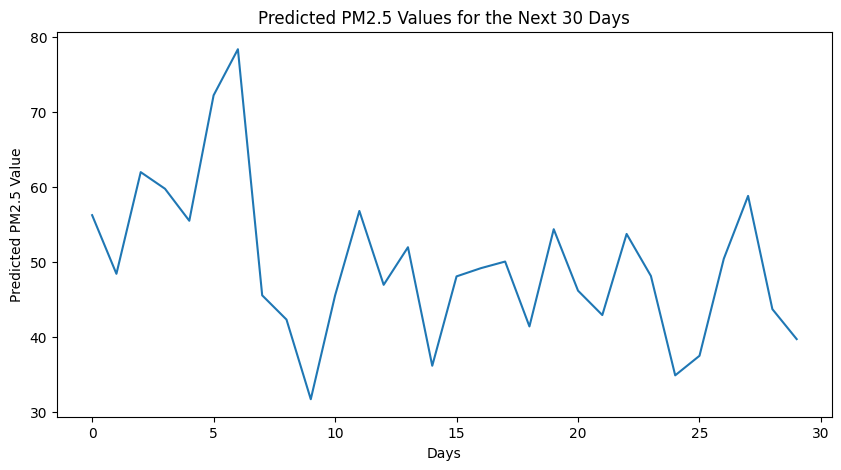

In [35]:
# Plot the predictions in the original scale
plt.figure(figsize=(10, 5))
plt.plot(predictions)
plt.title('Predicted PM2.5 Values for the Next 30 Days')
plt.xlabel('Days')
plt.ylabel('Predicted PM2.5 Value')
plt.show()